In [1]:
%reload_ext autoreload
%autoreload 2

from common_imports import *

In [20]:
system = Ps_system(N_atoms = 1,N_points = 100)
sequence = laser_sequence()
#system.init_distribution_MB()
system.init_distribution_flattop()
system.init_states_ground()
system.create_composite()

rabi0 = 2*np.pi*(250e-3)
chirp = 2*np.pi*(100e-3)
detuning0 = 0#2*np.pi*(250e-3)
direction = 1
pulse_duration = 10

opt_red = krotov.result.Result().load("data/krotov/archive_desymmetrization/desymmetrization_blue_detuned.pkl")
N = opt_red.tlist.size
red_detuning = opt_red.optimized_controls[0]+np.full(N,2*np.pi*(-400e-3))
red_envelope = opt_red.optimized_controls[2]
red_tlist = opt_red.tlist
red_kwargs = {
    "label":"desymmetrization",
    "order":0,
    "envelope":red_envelope,
    "detuning": red_detuning,
    "tlist":red_tlist,
    "unit_wavevector":direction
    }
sequence.init_pulse(red_kwargs)

laser_parameters = {"scale":1000,
               "rabi0" : rabi0,
                "pulse_duration" : pulse_duration,
                "start":0,
                "end":int(3*pulse_duration)}

N_pulses = 0

for i in range(N_pulses):
    laser_parameters["label"] = "cooling"+str(i)
    laser_parameters["order"] = i+1
    laser_parameters["detuning0"] = (-1)**i*detuning0
    laser_parameters["chirp"] = (-1)**i*chirp
    laser_parameters["unit_wavevector"] = (-1)**(i+1)*direction
    sequence.init_pulse(laser_parameters)


In [21]:
sorted_sequence = sequence.pull_sorted_sequence()
opts = qt.Options(store_states=True)
states = system.states
saved = [states]
results = []
#print(sorted_sequence)
for laser in sorted_sequence:
    laser = laser[1]
    system.set_Hamiltonian_MT_general_laser(laser)
    result = qt.sesolve(tlist=laser.tlist,psi0=states,H=system.H,e_ops=system.e_ops,options=opts)
    states = result.states[-1]
    results.append(result)
    saved.append(states)

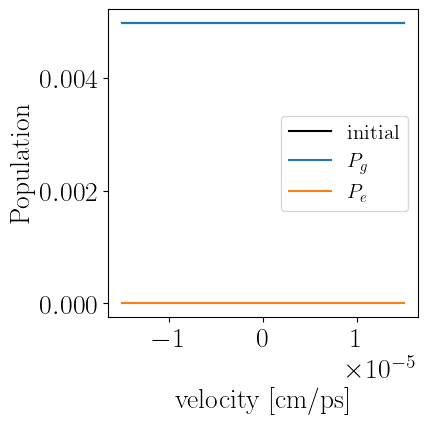

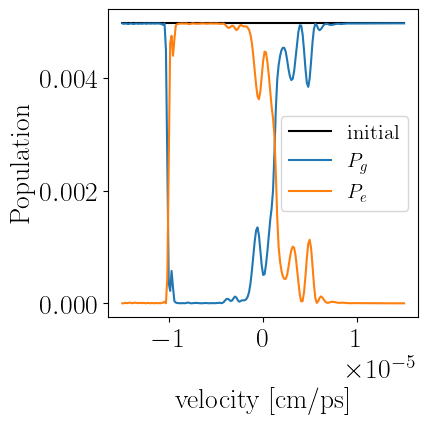

In [22]:

N = system.N_points
fig,ax = plt.subplots(figsize=(4,4))
ax.plot(system.velocity_bins, np.asarray(results[0].expect)[0:N,0]+np.asarray(results[0].expect)[N:N*2,0],label="initial",color="black")
ax.plot(system.velocity_bins, np.asarray(results[0].expect)[0:N,0],label=r"$P_g$")
ax.plot(system.velocity_bins, np.asarray(results[0].expect)[N:2*N,0],label=r"$P_e$")
ax.set_xlabel("velocity [cm/ps]",labelpad=25)
ax.set_ylabel("Population")
ax.legend(fontsize=15)
plt.show()
# fig,ax = plt.subplots(figsize=(4,4))
# ax.plot(system.velocity_bins, np.asarray(results[0].expect)[0:N,0]+np.asarray(results[0].expect)[N:N*2,0],label="initial",color="black")
# ax.plot(system.velocity_bins, np.asarray(results[0].expect)[0:N,-1],label=r"$P_g$")
# ax.plot(system.velocity_bins, np.asarray(results[0].expect)[N:2*N,-1],label=r"$P_e$")
# ax.set_xlabel("velocity [cm/ps]",labelpad=25)
# ax.set_ylabel("Population")
# ax.legend(fontsize=15)
# plt.show()
fig,ax = plt.subplots(figsize=(4,4))
ax.plot(system.velocity_bins, np.asarray(results[0].expect)[0:N,0]+np.asarray(results[0].expect)[N:N*2,0],label="initial",color="black")
ax.plot(system.velocity_bins, np.asarray(results[-1].expect)[0:N,-1],label=r"$P_g$")
ax.plot(system.velocity_bins, np.asarray(results[-1].expect)[N:2*N,-1],label=r"$P_e$")
ax.set_xlabel("velocity [cm/ps]",labelpad=25)
ax.set_ylabel("Population")
ax.legend(fontsize=15)
plt.show()

minimum: 25.52 after 20 pulses


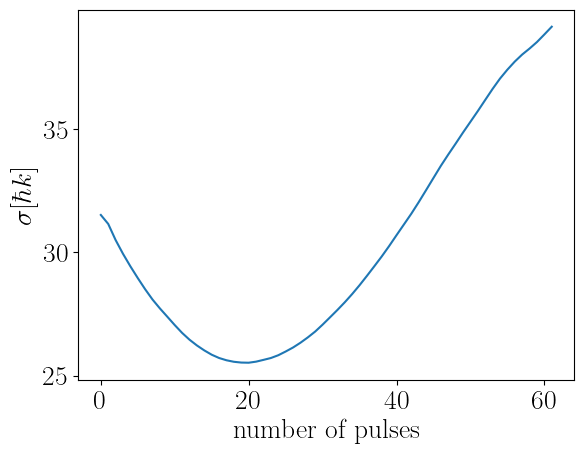

In [8]:
handler = data_handler()
stds = []
for state in saved:
    stds.append(handler.expect_standard_deviation(state,system.N_points))
plt.plot(np.arange(len(stds)),stds)
plt.ylabel(r"$\sigma [\hbar k]$")
plt.xlabel("number of pulses")
print("minimum: {:.2f} after {} pulses".format(np.amin(stds),np.argmin(stds)))

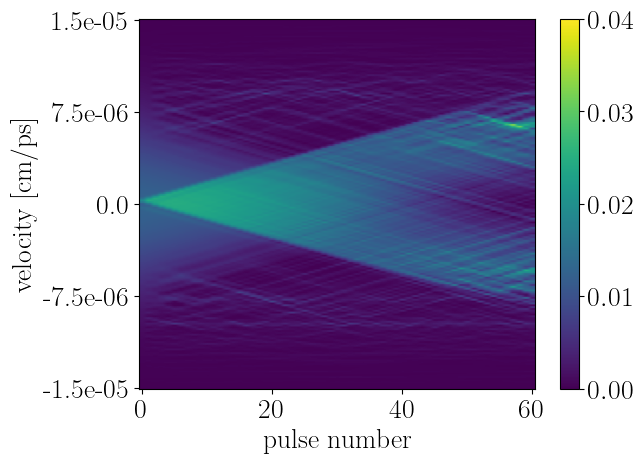

In [44]:
ground_population = []
excited_population = []
for result in results:
    ground_population.append(np.flip(np.asarray(result.expect)[0:N,-1]))
    excited_population.append(np.flip(np.asarray(result.expect)[N:N*2,-1]))
    #ground_population.append(np.asarray(result.expect)[0:N,-1])
    #excited_population.append(np.asarray(result.expect)[N:N*2,-1])
fig,ax=plt.subplots()
#imshow =ax.imshow(np.asarray(ground_population).T,aspect="auto")
imshow = ax.imshow((np.asarray(excited_population)+np.asarray(ground_population)).T,aspect="auto",vmin=0,vmax=0.04,)
ax.set_ylabel("velocity [cm/ps]")
#ax.set_yticks([system.velocity_bins[0]])
ax.set_yticks([0,50,100,150,200],np.flip([-1.5e-5,-7.5e-6,0,7.5e-6,1.5e-5]))
ax.set_xlabel("pulse number")
fig.colorbar(imshow)#boundaries=[0,0.01,0.02,0.03,0.04]
#plt.gca().clim(0,0.04)
#plt.savefig("figures/paper/modulated_transfer.svg")